In [1]:
import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy

import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPARATION

In [3]:
df = pd.read_excel('/content/drive/MyDrive/project-pkl/mhs_riwayat_status_ip_20181-20242.xlsx')
df.head()

,nim,jenjang_prodi,nama_prodi,fakultas,semester,status_semester,ip_semester,last_semester,last_status,ipk
0,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20191,NaN,3.64,20231,LULUS,3.66
1,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20192,AKTIF,3.68,20231,LULUS,3.66
2,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20201,AKTIF,3.69,20231,LULUS,3.66
3,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20202,AKTIF,3.66,20231,LULUS,3.66
4,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20211,AKTIF,3.54,20231,LULUS,3.66


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115644 entries, 0 to 115643
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   nim              115644 non-null  int64  
 1   jenjang_prodi    115644 non-null  object 
 2   nama_prodi       115644 non-null  object 
 3   fakultas         115644 non-null  object 
 4   semester         115644 non-null  int64  
 5   status_semester  115643 non-null  object 
 6   ip_semester      98258 non-null   float64
 7   last_semester    115644 non-null  int64  
 8   last_status      115644 non-null  object 
 9   ipk              115357 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 8.8+ MB


HANDLING MISSING VALUE WITH MEDIAN

# EDA (Exploratory Data Analysis)

In [6]:
df.head()

,nim,jenjang_prodi,nama_prodi,fakultas,semester,status_semester,ip_semester,last_semester,last_status,ipk
0,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20191,NaN,3.64,20231,LULUS,3.66
1,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20192,AKTIF,3.68,20231,LULUS,3.66
2,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20201,AKTIF,3.69,20231,LULUS,3.66
3,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20202,AKTIF,3.66,20231,LULUS,3.66
4,190104010122,S1,KOMUNIKASI DAN PENYIARAN ISLAM\t,DAKWAH DAN ILMU KOMUNIKASI,20211,AKTIF,3.54,20231,LULUS,3.66


# DISTRIBUSI VARIABEL CATEGORICAL

/tmp/ipython-input-1914920294.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




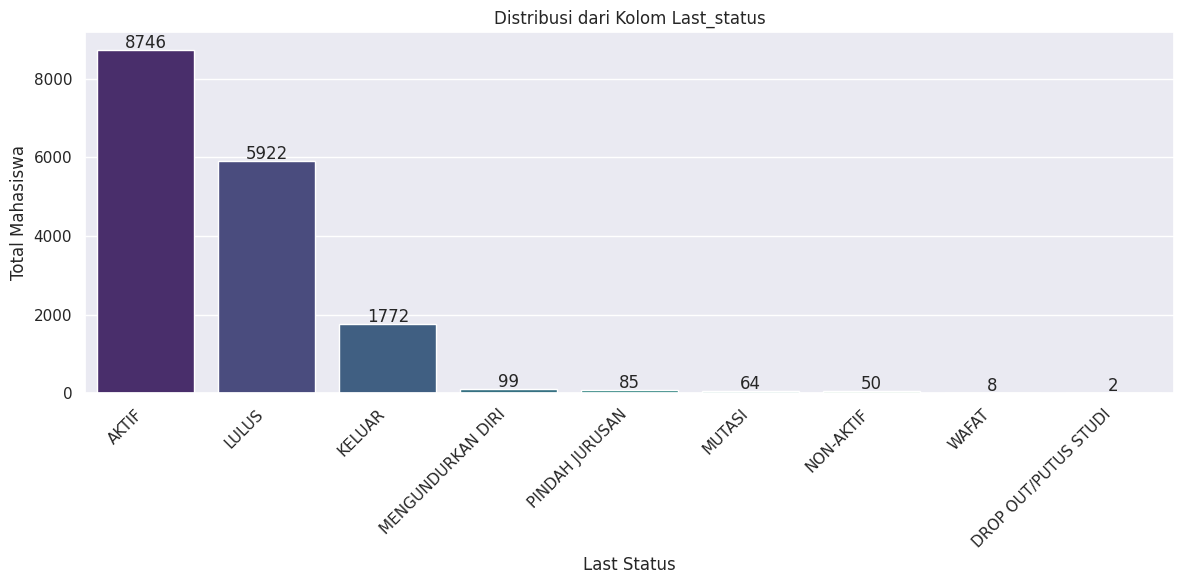

Jumlah mahasiswa : 16969


In [7]:
student_status = ['LULUS', 'AKTIF','KELUAR', 'MENGUNDURKAN DIRI', 'MUTASI', 'PINDAH JURUSAN', 'NON-AKTIF', 'WAFAT', 'DROP OUT/PUTUS STUDI']
df_status = df[df['last_status'].isin(student_status)]

unique_ids_student = df_status.drop_duplicates(subset=['nim'])

status_count_student = unique_ids_student['last_status'].value_counts()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=status_count_student.index, y=status_count_student.values, palette='viridis')
plt.title('Distribusi dari Kolom Last_status')
plt.xlabel('Last Status')
plt.ylabel('Total Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()
jumlah_mahasiswa = df['nim'].nunique()
print(f"Jumlah mahasiswa : {jumlah_mahasiswa}")

## INSIGHT
Ada 1772 orang yang keluar, kita harus menyelidiki apa yang menjadi penyebab mahasiswa-mahasiswa tersebut keluar

/tmp/ipython-input-757949560.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




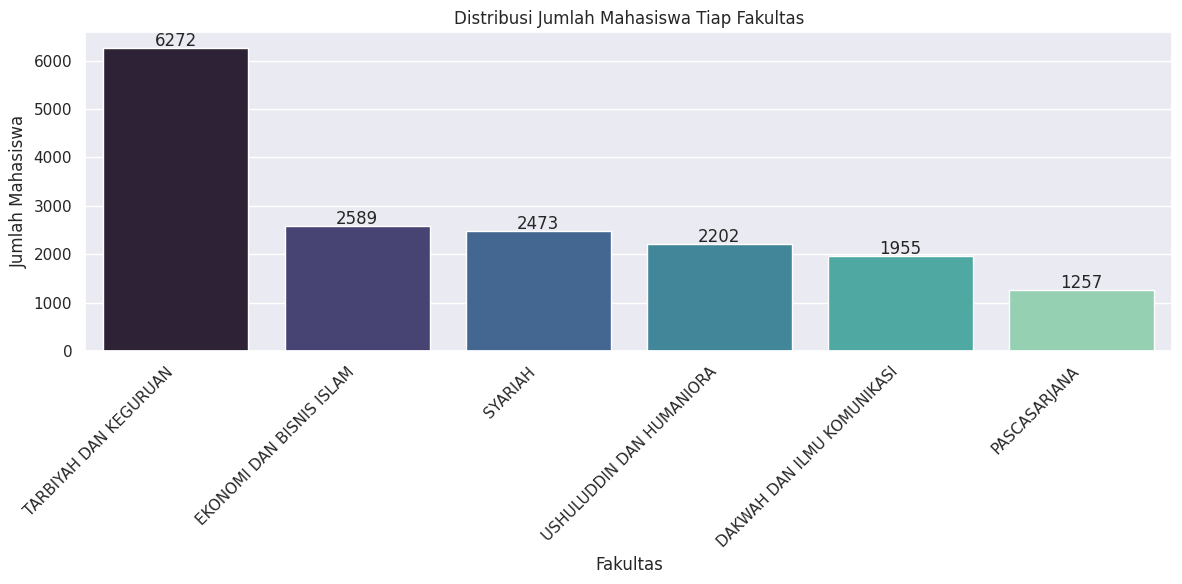

In [8]:
# Hitung jumlah mahasiswa unik per fakultas
mahasiswa_per_fakultas = unique_ids_student['fakultas'].value_counts()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mahasiswa_per_fakultas.index, y=mahasiswa_per_fakultas.values, palette='mako')
plt.title('Distribusi Jumlah Mahasiswa Tiap Fakultas')
plt.xlabel('Fakultas')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

/tmp/ipython-input-1531516044.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




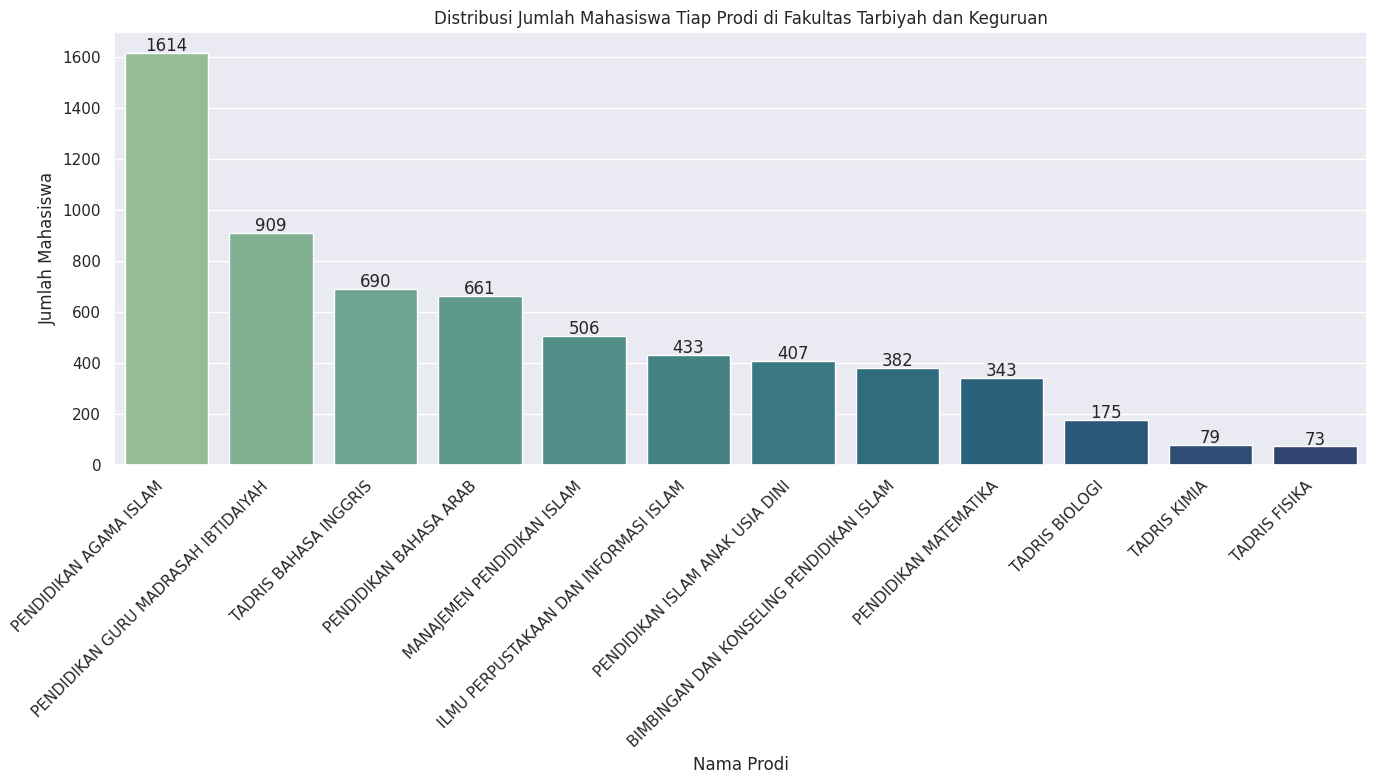

In [9]:
# Filter unique students in Fakultas Tarbiyah dan Keguruan
tarbiyah_students = unique_ids_student[unique_ids_student['fakultas'] == 'TARBIYAH DAN KEGURUAN']

# Count number of students per 'nama_prodi'
prodi_counts = tarbiyah_students['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas Tarbiyah dan Keguruan')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## INSIGHT
Prodi pendidikan Agama Islam memiliki paling banyak mahasiswa, sementara Tadris Fisika yang paling sedikit di fakultas Tarbiyah dan Keguruan

/tmp/ipython-input-4234059659.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




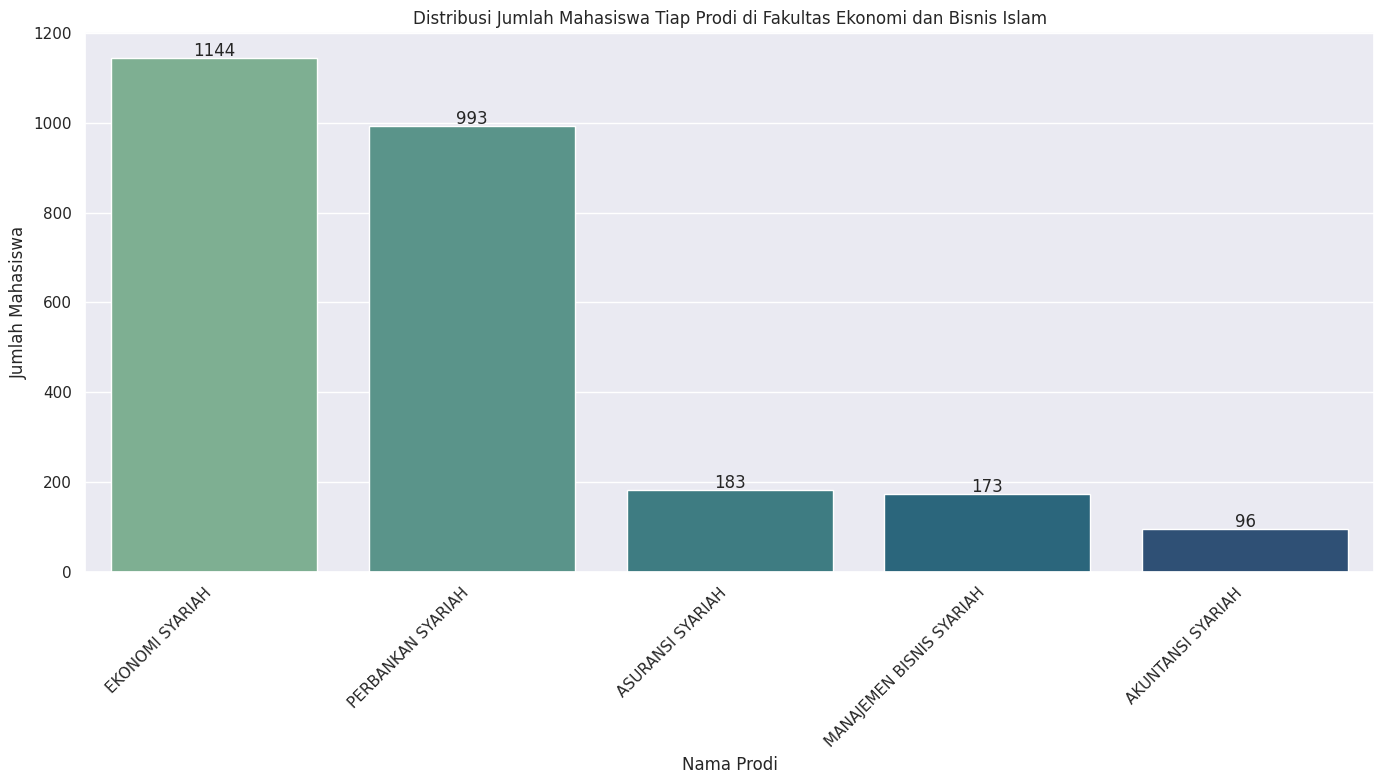

In [10]:
# Filter unique students in Fakultas Ekonomi dan Bisnis Islam
mahasiswa_ekonomi = unique_ids_student[unique_ids_student['fakultas'] == 'EKONOMI DAN BISNIS ISLAM']

# Count number of students per 'nama_prodi'
prodi_counts = mahasiswa_ekonomi['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas Ekonomi dan Bisnis Islam')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## INSIGHT
di Fakultas Ekonomi dan Bisnis Islam prodi Ekonomi Syariah memiliki paling banyak mahasiswa, sementara prodi Akuntansi Syariah yang paling sedikit

/tmp/ipython-input-3127346721.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




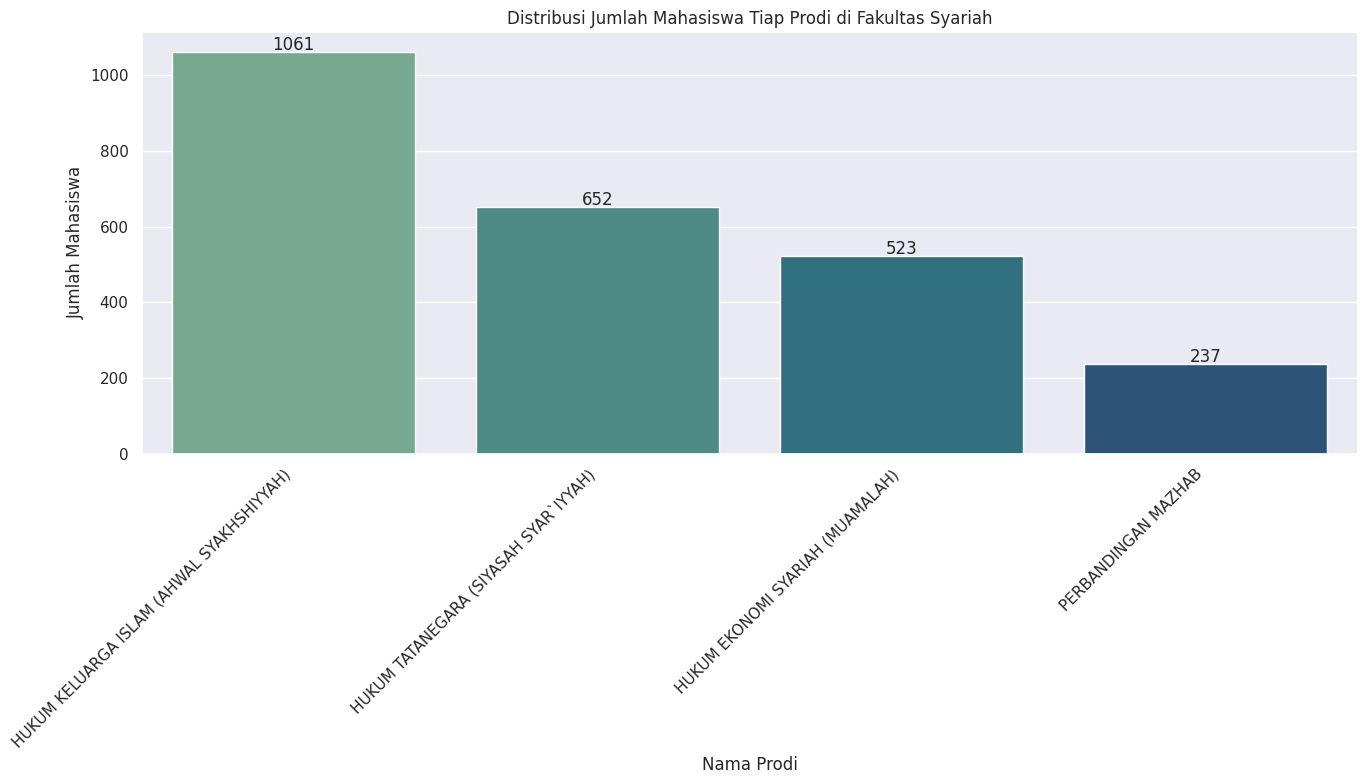

In [11]:
mahasiswa_syariah = unique_ids_student[unique_ids_student['fakultas'] == 'SYARIAH']

# Count number of students per 'nama_prodi'
prodi_counts = mahasiswa_syariah['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas Syariah')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

Di fakultas Syariah, prodi Hukum Keluarga Islam memiliki paling banyak mahasiswa, sementara prodi Perbandingan Mazhab  yang paling sedikit memiliki mahasiswa

/tmp/ipython-input-1494171547.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




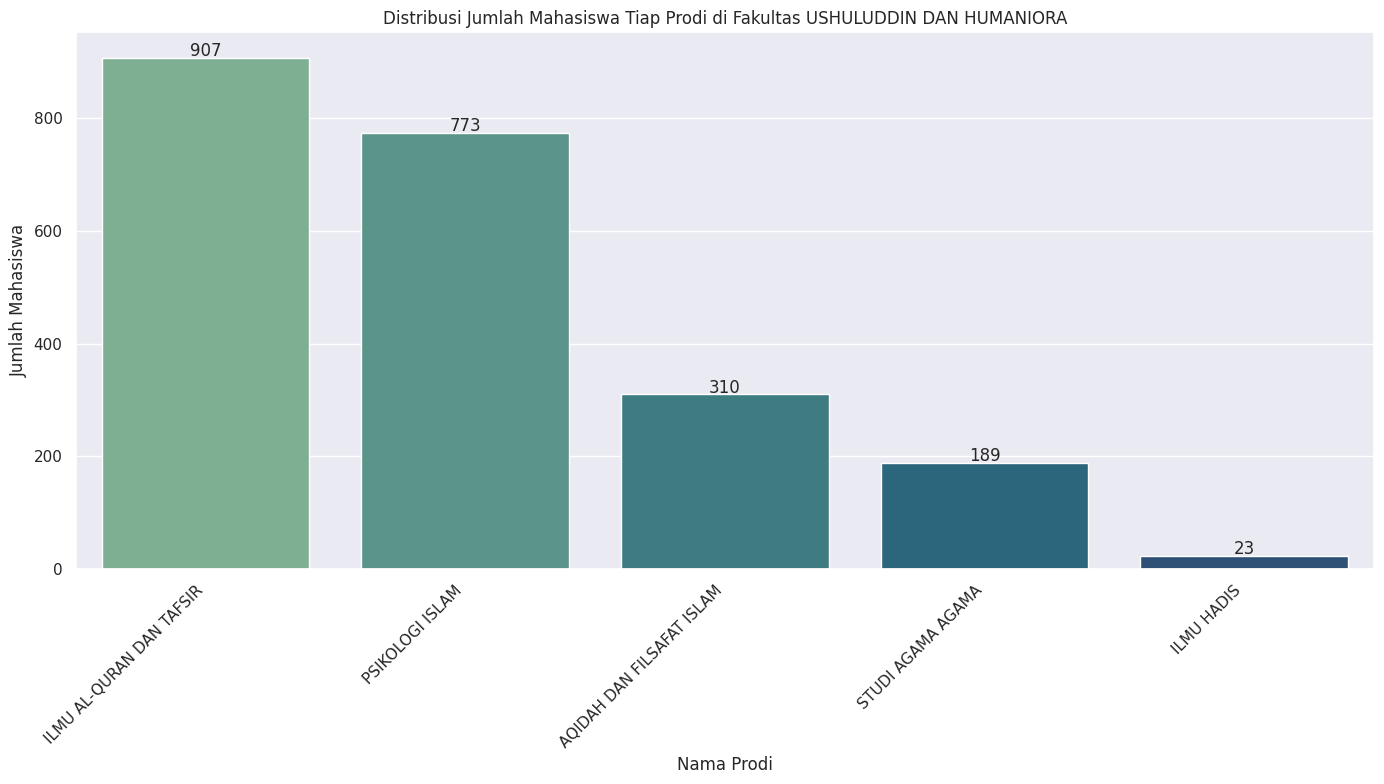

In [12]:
mahasiswa_ushuluddin = unique_ids_student[unique_ids_student['fakultas'] == 'USHULUDDIN DAN HUMANIORA']

# Count number of students per 'nama_prodi'
prodi_counts = mahasiswa_ushuluddin['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas USHULUDDIN DAN HUMANIORA')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

/tmp/ipython-input-1634366482.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1634366482.py:13: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



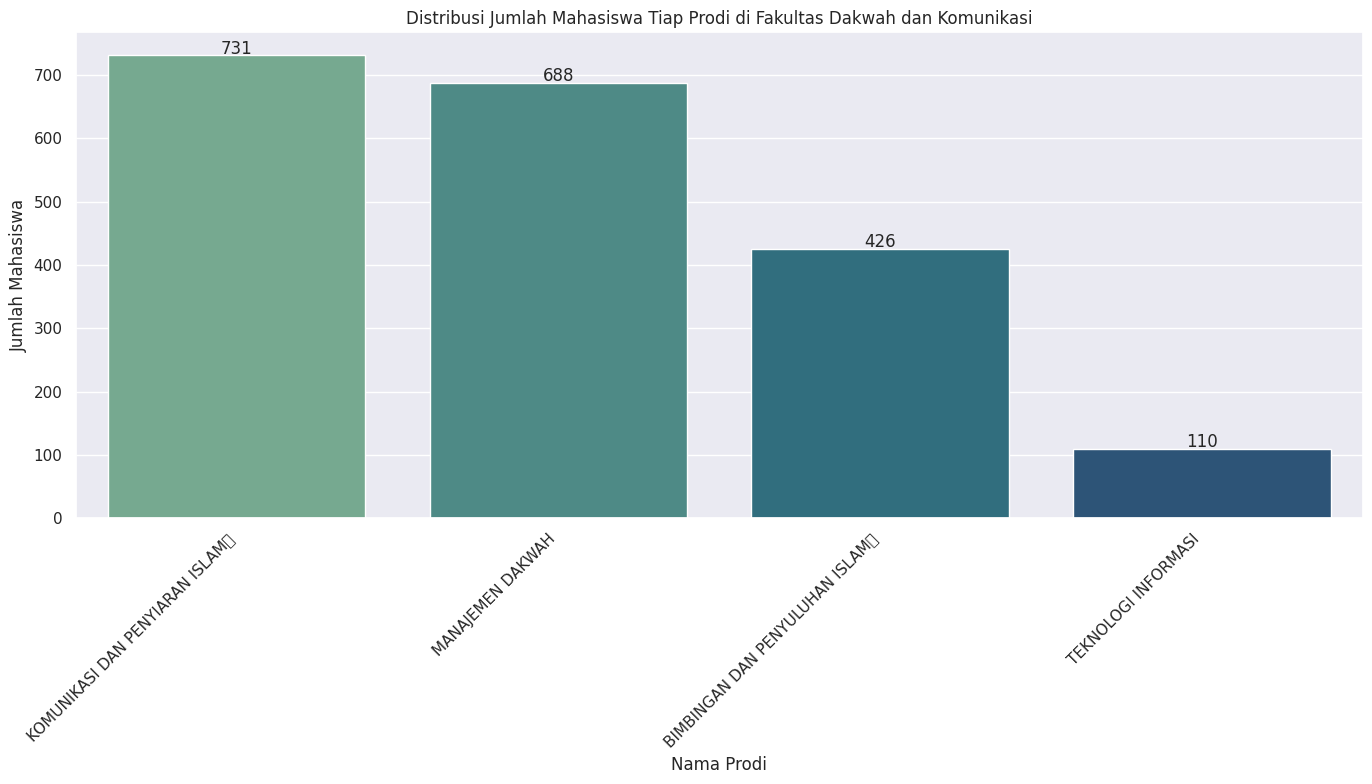

In [13]:
# Filter unique students in Fakultas Tarbiyah dan Keguruan
mahasiswa_dakwah = unique_ids_student[unique_ids_student['fakultas'] == 'DAKWAH DAN ILMU KOMUNIKASI']

# Count number of students per 'nama_prodi'
prodi_counts = mahasiswa_dakwah['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas Dakwah dan Komunikasi')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## INSIGHT
Di fakultas Dakwah dan Ilmu Komunikasi prodi Komunikasi dan Penyiaran Islam Memiliki paling banyak Mahasiswa, sedangkan prodi Teknologi Informasi yang paling sedikit memiliki mahasiswa

/tmp/ipython-input-2904665118.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-2904665118.py:11: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



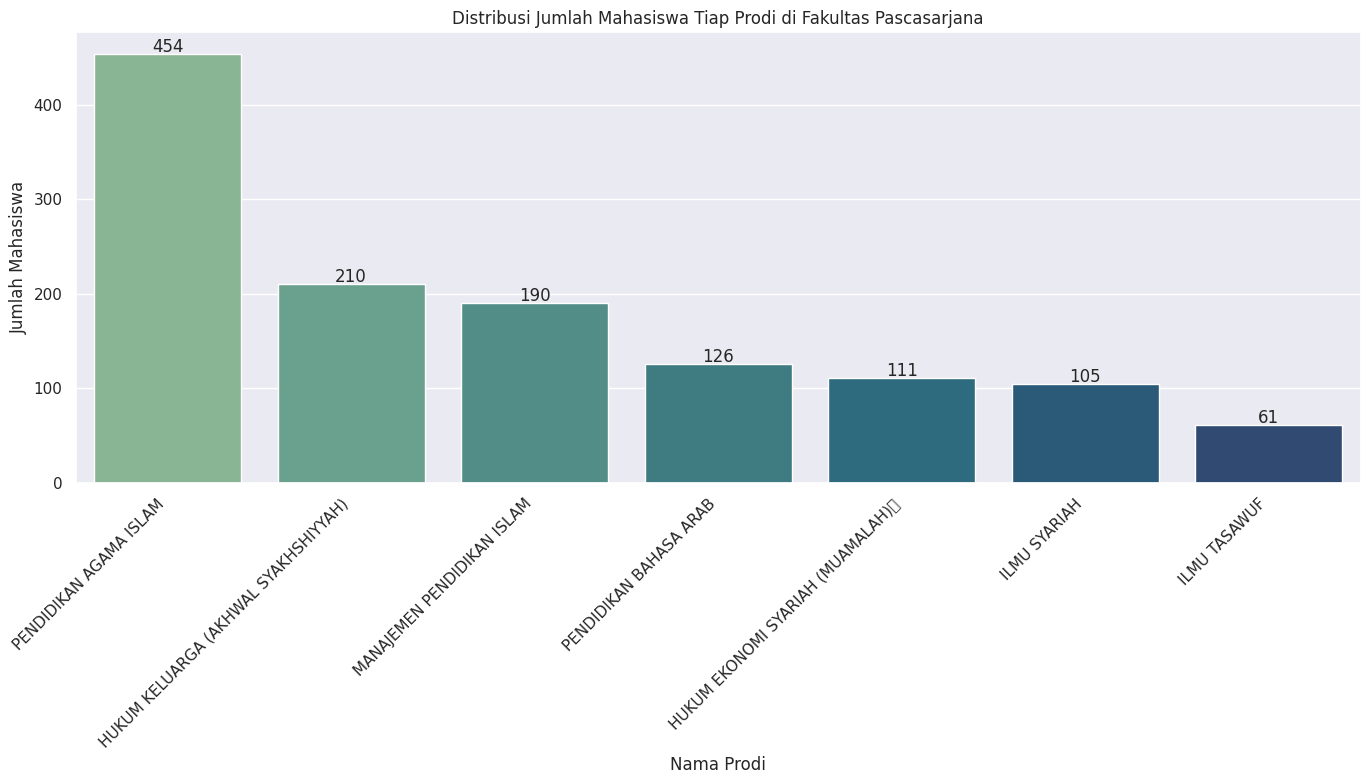

In [14]:
mahasiswa_pascasarjana = unique_ids_student[unique_ids_student['fakultas'] == 'PASCASARJANA']

prodi_counts = mahasiswa_pascasarjana['nama_prodi'].value_counts()

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=prodi_counts.index, y=prodi_counts.values, palette='crest')
plt.title('Distribusi Jumlah Mahasiswa Tiap Prodi di Fakultas Pascasarjana')
plt.xlabel('Nama Prodi')
plt.ylabel('Jumlah Mahasiswa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## INSIGHT
Di fakultas Pascasarjana prodi Pendidikan Agama Islam memiliki paling banyak mahasiswa, sedangkan produ Ilmu Tasawuf yang paling sedikit memiliki mahasiswa

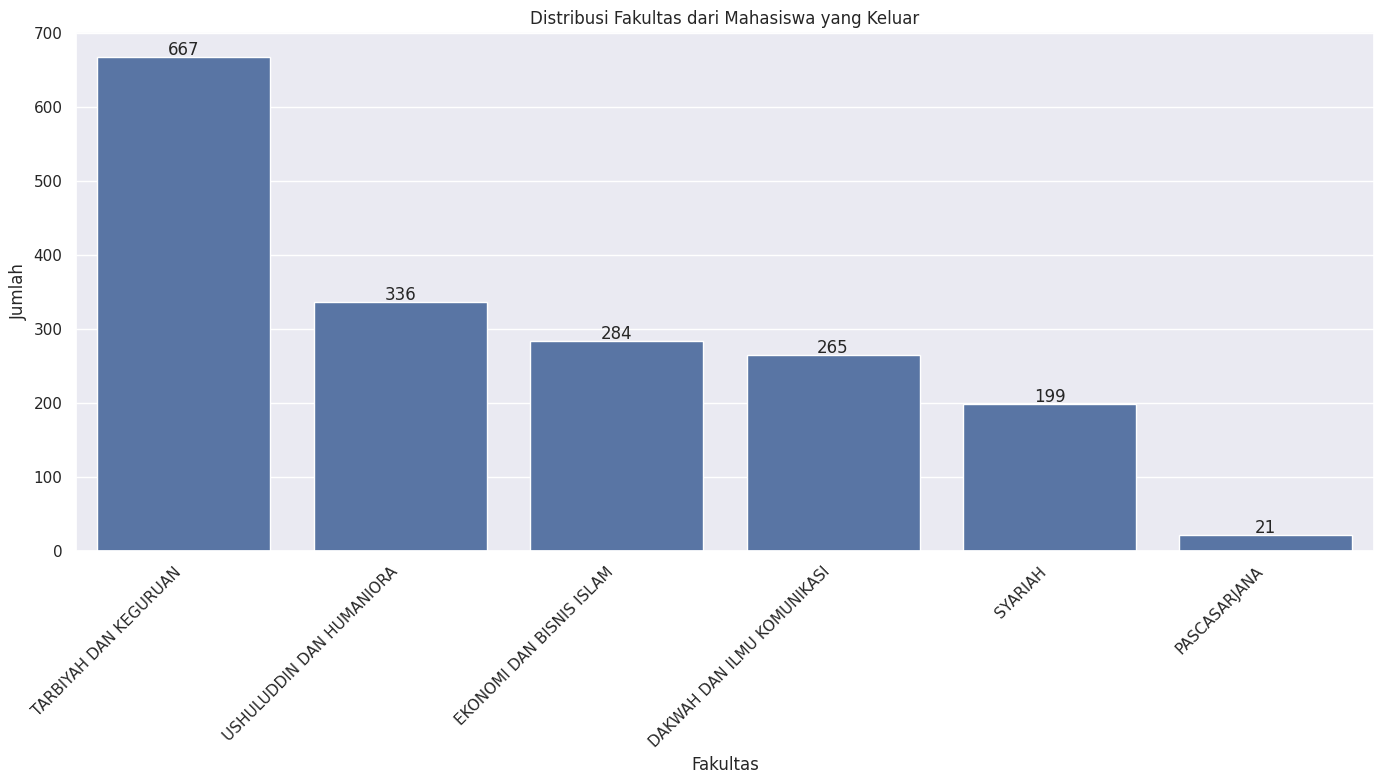

In [15]:
keluar_mahasiswa = df[df['last_status'] == 'KELUAR']

unique_keluar_mahasiswa = keluar_mahasiswa.drop_duplicates(subset=['nim'])

plt.figure(figsize=(14, 8))
ax = sns.countplot(data=unique_keluar_mahasiswa, x='fakultas', order=unique_keluar_mahasiswa['fakultas'].value_counts().index)
plt.title('Distribusi Fakultas dari Mahasiswa yang Keluar')
plt.xlabel('Fakultas')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

## INSIGHT
Fakultas Tarbiyahdan Keguruan paling banyak 'menyumbang' mahasiswa yang keluar, ini masuk akal karena fakultas tarbiyah dan keguruan memiliki lebih banyak mahasiswa daripada fakultas lain

In [16]:
students_ipk_keluar = df[(df['ipk'] < 3) & (df['last_status'] == 'KELUAR')]

num_unique_students = students_ipk_keluar['nim'].nunique()

print(f"Jumlah unique ID dengan IPK < 3 dan status 'KELUAR': {num_unique_students}")

Jumlah unique ID dengan IPK < 3 dan status 'KELUAR': 1018


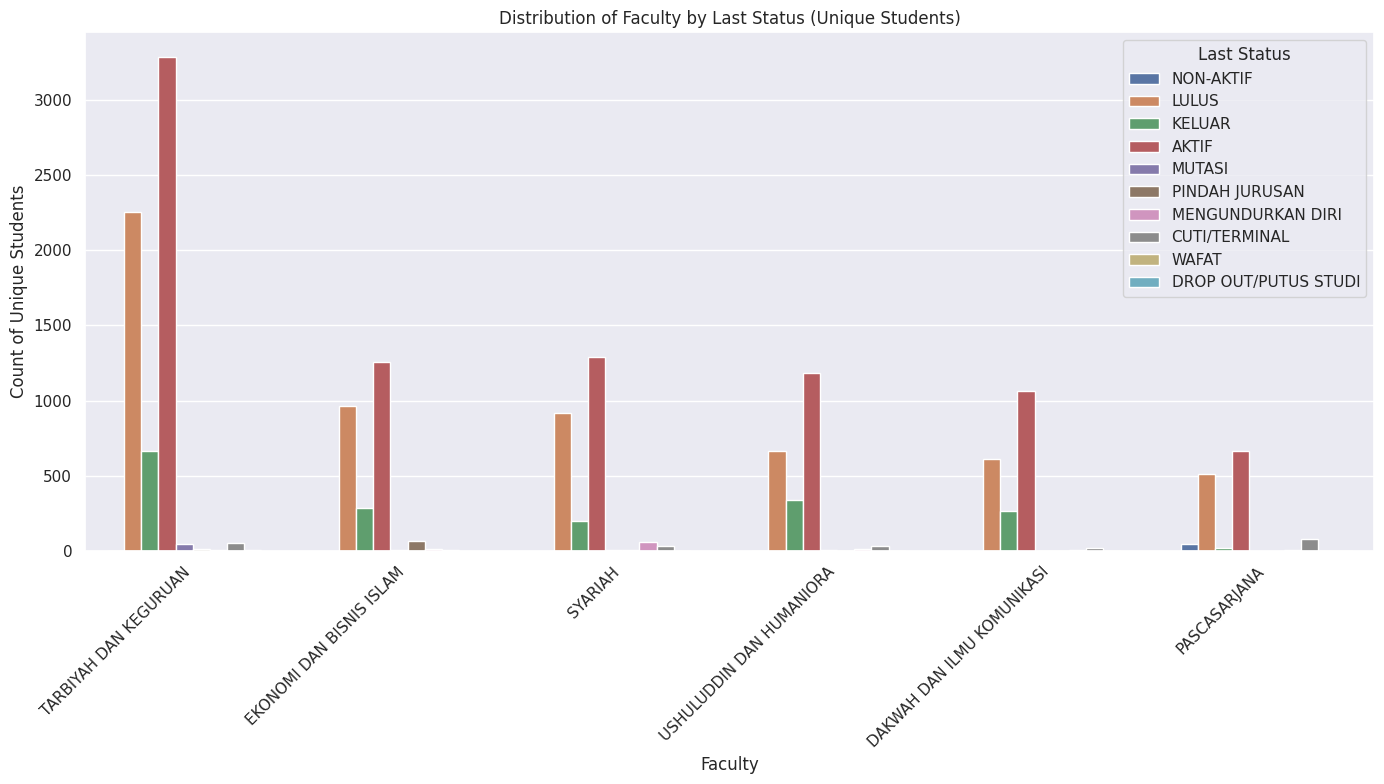

In [17]:
last_status_per_student = df.groupby('nim').agg({
    'fakultas': 'first',
    'last_status': 'last'
}).reset_index()

plt.figure(figsize=(14, 8))
sns.countplot(data=last_status_per_student, x='fakultas', hue='last_status', order=last_status_per_student['fakultas'].value_counts().index)
plt.title('Distribution of Faculty by Last Status (Unique Students)')
plt.xlabel('Faculty')
plt.ylabel('Count of Unique Students')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Last Status')
plt.tight_layout()
plt.show()

# DISTRIBUSI VARIABEL NUMERIK

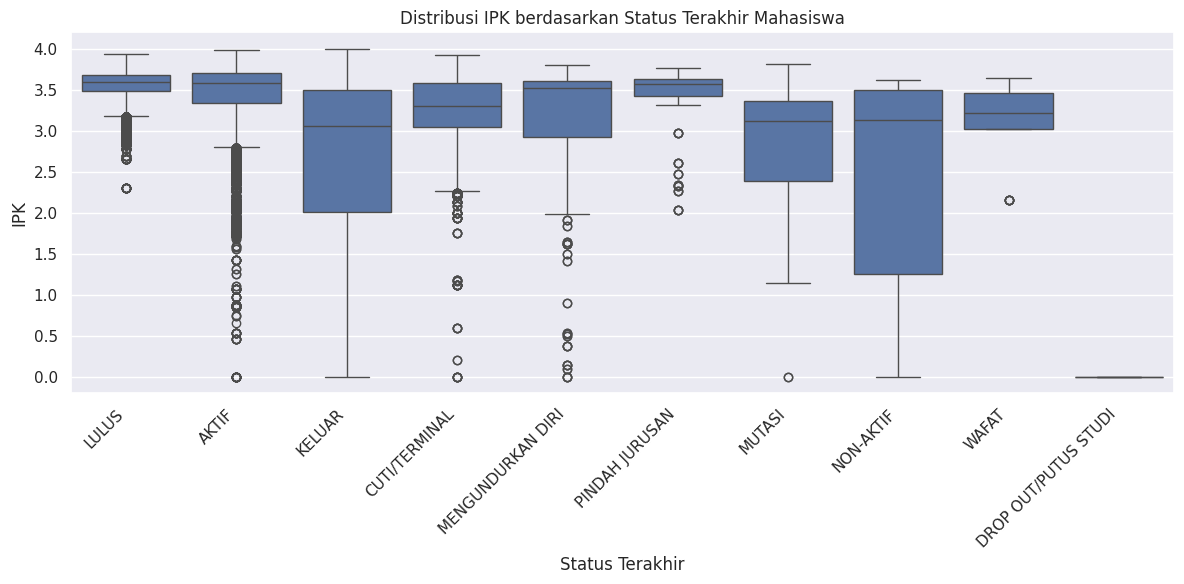

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='last_status', y='ipk', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi IPK berdasarkan Status Terakhir Mahasiswa')
plt.xlabel('Status Terakhir')
plt.ylabel('IPK')
plt.tight_layout()
plt.show()

## INSIGHT
1. Mahasiswa Lulus dan Aktif Memiliki IPK Tinggi dengan median IPK di sekitar 3.5–3.6, menunjukkan performa akademik yang konsisten baik.
Sebagian besar mahasiswa yang lulus memiliki IPK tinggi dan variansi yang kecil artinya mereka umumnya stabil dalam performa akademik.

2. Status “Keluar”, “Cuti/Terminal”, dan “Mengundurkan Diri” Menunjukkan IPK yang Lebih Rendah. Ketiga kategori ini memiliki median IPK sekitar 2.8–3.1, dengan banyak outlier rendah (bahkan 0).
Ini bisa menunjukkan bahwa rendahnya performa akademik menjadi salah satu faktor mahasiswa keluar atau berhenti studi.

## Kesimpulan
* IPK tinggi cenderung berasosiasi dengan status “Lulus” atau “Aktif”.

* IPK rendah banyak ditemukan pada status “Keluar”, “Cuti”, “Mengundurkan diri”, atau “Non-aktif”.

* Faktor non-akademik (misalnya wafat, mutasi, pindah jurusan) menunjukkan distribusi IPK yang tidak selalu rendah.

In [19]:
numerical_cols = ['ip_semester', 'ipk']

for col in numerical_cols:
    fig = px.histogram(df, x=col, title=f'Distribusi dari {col}')
    fig.show()

## INSIGHT
* Pada grafik distribusi IP Semester, terlihat bahwa data bersifat tidak merata dan cenderung condong ke kanan. Sebagian besar mahasiswa memiliki IP semester di kisaran 3.5 hingga 3.8, menandakan performa akademik yang cukup baik pada tiap periode perkuliahan. Namun, terdapat kelompok yang cukup besar dengan nilai IP = 0, yang kemungkinan besar disebabkan oleh mahasiswa yang tidak aktif, cuti, mengundurkan diri, atau memiliki data nilai yang belum tercatat

* grafik distribusi IPK menunjukkan pola yang lebih halus dan stabil, dengan mayoritas nilai IPK berkisar antara 3.0 hingga 3.7 dan puncak distribusi berada di sekitar 3.5. Hal ini mengindikasikan bahwa secara kumulatif, mahasiswa cenderung mempertahankan performa akademik yang baik sepanjang masa studi. Nilai IPK yang sangat rendah (di bawah 2.0) atau 0 muncul dalam jumlah yang relatif kecil, menunjukkan bahwa hanya sebagian kecil mahasiswa yang mengalami kesulitan akademik secara berkelanjutan.

# DATA PREPROCESSING

* Membuat fitur baru (feature engineering)

* Handling Categorical & Numerical variabel

* Encoded

* Handling class imbalance menggunakan metode SMOTE

* Feature Scaling

* Feature Selection


In [20]:
# Bersihkan kolom 'fakultas' dari karakter tambahan di akhir, seperti '/t' atau spasi
df['nama_prodi'] = df['nama_prodi'].str.strip().str.replace(r'[\t\s]+$', '', regex=True)

print(df['nama_prodi'].unique())

['KOMUNIKASI DAN PENYIARAN ISLAM' 'MANAJEMEN DAKWAH'
 'BIMBINGAN DAN PENYULUHAN ISLAM' 'EKONOMI SYARIAH' 'PERBANKAN SYARIAH'
 'ASURANSI SYARIAH' 'HUKUM EKONOMI SYARIAH (MUAMALAH)'
 'MANAJEMEN PENDIDIKAN ISLAM' 'PENDIDIKAN AGAMA ISLAM'
 'PENDIDIKAN BAHASA ARAB' 'ILMU SYARIAH'
 'HUKUM KELUARGA (AKHWAL SYAKHSHIYYAH)' 'ILMU TASAWUF'
 'PERBANDINGAN MAZHAB' 'HUKUM KELUARGA ISLAM (AHWAL SYAKHSHIYYAH)'
 'HUKUM TATANEGARA (SIYASAH SYAR`IYYAH)' 'PENDIDIKAN ISLAM ANAK USIA DINI'
 'PENDIDIKAN GURU MADRASAH IBTIDAIYAH'
 'ILMU PERPUSTAKAAN DAN INFORMASI ISLAM' 'TADRIS BAHASA INGGRIS'
 'BIMBINGAN DAN KONSELING PENDIDIKAN ISLAM' 'PENDIDIKAN MATEMATIKA'
 'TADRIS BIOLOGI' 'TADRIS FISIKA' 'TADRIS KIMIA'
 'ILMU AL-QURAN DAN TAFSIR' 'AQIDAH DAN FILSAFAT ISLAM' 'PSIKOLOGI ISLAM'
 'STUDI AGAMA AGAMA' 'TEKNOLOGI INFORMASI' 'MANAJEMEN BISNIS SYARIAH'
 'AKUNTANSI SYARIAH' 'ILMU HADIS']


## Membuat fitur "target_kelulusan_semester" sebagai target baru

In [24]:
def classify_student_outcome(row):
    if row['last_status'] == 'LULUS':
        if row['ipk'] >= 3.5:
            return 'LULUS DENGAN PREDIKAT TINGGI'
        elif row['ipk'] >= 3.0:
            return 'LULUS DENGAN PREDIKAT BAIK'
        else:
            return 'LULUS DENGAN PREDIKAT CUKUP'
    elif row['last_status'] in ['KELUAR', 'MENGUNDURKAN DIRI', 'DROP OUT/PUTUS STUDI']:
        if row['ipk'] < 3.0:
            return 'TIDAK LULUS KARENA AKADEMIK'
        else:
            return 'TIDAK LULUS KARENA NON-AKADEMIK'
    elif row['last_status'] in ['NON-AKTIF', 'CUTI']:
         return 'STATUS TIDAK AKTIF'
    else:
        return 'LAINNYA' # For statuses like AKTIF, MUTASI, PINDAH JURUSAN, WAFAT

df['target_outcome'] = df.apply(classify_student_outcome, axis=1)

display(df[['last_status', 'ipk', 'target_outcome']].head())
display(df['target_outcome'].value_counts())

,last_status,ipk,target_outcome
84614,NON-AKTIF,3.57,STATUS TIDAK AKTIF
27952,LULUS,3.42,LULUS DENGAN PREDIKAT BAIK
27951,LULUS,3.42,LULUS DENGAN PREDIKAT BAIK
27950,LULUS,3.42,LULUS DENGAN PREDIKAT BAIK
27953,LULUS,3.42,LULUS DENGAN PREDIKAT BAIK


,count
target_outcome,
LAINNYA,53436
LULUS DENGAN PREDIKAT TINGGI,38978
LULUS DENGAN PREDIKAT BAIK,14308
TIDAK LULUS KARENA NON-AKADEMIK,4483
TIDAK LULUS KARENA AKADEMIK,3811
LULUS DENGAN PREDIKAT CUKUP,501
STATUS TIDAK AKTIF,127


## Encode the new target variable

In [25]:
# Encode the new target variable 'target_outcome'
# You can use LabelEncoder or map the categories to numerical values
# For simplicity, we will use mapping based on the value counts observed
outcome_mapping = {
    'LAINNYA': 0,
    'LULUS DENGAN PREDIKAT TINGGI': 1,
    'LULUS DENGAN PREDIKAT BAIK': 2,
    'TIDAK LULUS KARENA NON-AKADEMIK': 3,
    'TIDAK LULUS KARENA AKADEMIK': 4,
    'LULUS DENGAN PREDIKAT CUKUP': 5,
    'STATUS TIDAK AKTIF': 6
}

# Add the 'target_outcome' column to df_encoded before mapping
df_encoded['target_outcome'] = df['target_outcome']
df_encoded['target_outcome_numeric'] = df_encoded['target_outcome'].map(outcome_mapping)

display(df_encoded[['target_outcome', 'target_outcome_numeric']].head())
display(df_encoded['target_outcome_numeric'].value_counts())

,target_outcome,target_outcome_numeric
84614,STATUS TIDAK AKTIF,6
27952,LULUS DENGAN PREDIKAT BAIK,2
27951,LULUS DENGAN PREDIKAT BAIK,2
27950,LULUS DENGAN PREDIKAT BAIK,2
27953,LULUS DENGAN PREDIKAT BAIK,2


,count
target_outcome_numeric,
0,53436
1,38978
2,14308
3,4483
4,3811
5,501
6,127


## Train neural network model

### Subtask:
Re-train the Neural Network model using the SMOTE-resampled data with the updated target.


**Reasoning**:
Define and compile the Neural Network model with the updated output layer for the new target variable, set up Early Stopping, and train the model using the SMOTE-resampled data.



In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Layer 1 - Lebih banyak neuron
model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=regularizers.l2(0.0001)))  # Regularisasi lebih kecil
model.add(BatchNormalization())  # Tambahkan BatchNorm
model.add(Dropout(0.2))  # Dropout lebih kecil

# Layer 2
model.add(Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3 - Tambah layer
model.add(Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 4 - Optional, tambah kedalaman
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(len(y_train.unique()), activation='softmax'))

# Learning rate lebih besar
optimizer = Adam(learning_rate=0.001)  # Naikkan dari 0.0001

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early Stopping dengan patience lebih besar
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Lebih sabar
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi LR jadi setengahnya
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Training
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,  # Lebih banyak epoch
    batch_size=32,  # Batch size lebih kecil untuk learning lebih baik
    validation_data=(X_test_scaled, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,007 (218.78 KB)

 Trainable params: 55,111 (215.28 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4722 - loss: 1.2929 - val_accuracy: 0.6053 - val_loss: 0.8667 - learning_rate: 0.0010
Epoch 2/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5843 - loss: 0.9231 - val_accuracy: 0.6237 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 3/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.5987 - loss: 0.8908 - val_accuracy: 0.6127 - val_loss: 0.8448 - learning_rate: 0.0010
Epoch 4/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5982 - loss: 0.8778 - val_accuracy: 0.6042 - val_loss: 0.8619 - learning_rate: 0.0010
Epoch 5/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.6098 - loss: 0.8636 - val_accuracy: 0.6292 - val_loss: 0.8088 - learning_rate: 0.0010
Epoch 6/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6097 - loss: 0.8578 - val_accuracy: 0.6174 - val_loss: 0.8362 - learning_rate: 0.0010
Epoch 7/200
2892/2892 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accura

KeyboardInterrupt: 

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the training data (scaled data that was actually used for training)
y_pred_train_prob = model.predict(X_train_scaled)
y_pred_train = np.argmax(y_pred_train_prob, axis=1)

# Generate confusion matrix for training data
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Data (Actual Data Used for Training)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for training data
print("Classification Report - Training Data:")
print(classification_report(y_train, y_pred_train))

In [ ]:
print("Features used for training:")
for feature in features:
    print(feature)

# Task
Create new features `durasi_studi_semester`, `perubahan_ip_semester`, and `rata_rata_ip_per_mahasiswa` in the DataFrame `df` by inserting a new code cell after the cell `tl_-Bc9PAr9M`, and then re-run the notebook starting from this newly added cell. Note that the feature `usia_saat_semester_awal` cannot be created as the 'tanggal_lahir' column is missing from the dataset.

## Add new feature engineering cell

### Subtask:
Create new features `durasi_studi_semester`, `perubahan_ip_semester`, and `rata_rata_ip_per_mahasiswa` in the DataFrame `df`.


**Reasoning**:
I will create the three new features as requested: `durasi_studi_semester` by subtracting 1 from `semester_ke`, `perubahan_ip_semester` by calculating the difference in `ip_semester` per student and filling NaNs with 0, and `rata_rata_ip_per_mahasiswa` by computing the mean `ip_semester` for each student. Finally, I will display the first few rows of the DataFrame including these new features to verify the creation.



In [30]:
df['durasi_studi_semester'] = df['semester_ke'] - 1

df['perubahan_ip_semester'] = df.groupby('nim')['ip_semester'].diff().fillna(0)

# Calculate rata_rata_ip_per_mahasiswa for each student and then map it back to the original DataFrame
df['rata_rata_ip_per_mahasiswa'] = df.groupby('nim')['ip_semester'].transform('mean')

display(df[['nim', 'semester_ke', 'durasi_studi_semester', 'ip_semester', 'perubahan_ip_semester', 'rata_rata_ip_per_mahasiswa']].head())

,nim,semester_ke,durasi_studi_semester,ip_semester,perubahan_ip_semester,rata_rata_ip_per_mahasiswa
84614,18010340255,1,0,3.68,0.00,3.680000
27952,170102061285,1,0,3.31,0.00,3.282727
27951,170102061285,2,1,3.75,0.44,3.282727
27950,170102061285,3,2,3.38,-0.37,3.282727
27953,170102061285,4,3,3.36,-0.02,3.282727


**Reasoning**:
Now that the new numerical features have been added to the `df` DataFrame, I need to re-encode the categorical features to ensure that `df_encoded` is updated with these new features before proceeding with feature selection and model training. The previous `df_encoded` does not contain `durasi_studi_semester`, `perubahan_ip_semester`, and `rata_rata_ip_per_mahasiswa`.



In [31]:
categorical_features = ['fakultas', 'nama_prodi']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print("Data setelah One-Hot Encoding:")
display(df_encoded.head())

Data setelah One-Hot Encoding:


,nim,jenjang_prodi,semester,status_semester,ip_semester,last_semester,last_status,ipk,semester_ke,bobot_jenjang,...,nama_prodi_PENDIDIKAN MATEMATIKA,nama_prodi_PERBANDINGAN MAZHAB,nama_prodi_PERBANKAN SYARIAH,nama_prodi_PSIKOLOGI ISLAM,nama_prodi_STUDI AGAMA AGAMA,nama_prodi_TADRIS BAHASA INGGRIS,nama_prodi_TADRIS BIOLOGI,nama_prodi_TADRIS FISIKA,nama_prodi_TADRIS KIMIA,nama_prodi_TEKNOLOGI INFORMASI
84614,18010340255,S1,20191,NON-AKTIF,3.68,20191,NON-AKTIF,3.57,1,2,...,False,False,False,True,False,False,False,False,False,False
27952,170102061285,S1,20181,AKTIF,3.31,20231,LULUS,3.42,1,2,...,False,False,False,False,False,False,False,False,False,False
27951,170102061285,S1,20182,AKTIF,3.75,20231,LULUS,3.42,2,2,...,False,False,False,False,False,False,False,False,False,False
27950,170102061285,S1,20191,AKTIF,3.38,20231,LULUS,3.42,3,2,...,False,False,False,False,False,False,False,False,False,False
27953,170102061285,S1,20192,AKTIF,3.36,20231,LULUS,3.42,4,2,...,False,False,False,False,False,False,False,False,False,False


**Reasoning**:
The previous `X` and `y` were defined using the `df_encoded` before the new features were added and before `df_encoded` was re-created. Therefore, I need to redefine `X` and `y` with the updated `df_encoded` and then split the data again into training and testing sets to reflect the inclusion of the new features. The `target_outcome` column should also be mapped to its numerical representation after re-creating `df_encoded`.



In [32]:
# Map the 'target_outcome' column to its numerical representation
# This step is necessary because df_encoded was recreated, and the mapping was lost.
df_encoded['target_outcome_numeric'] = df_encoded['target_outcome'].map(outcome_mapping)

# Define features and target
features = [col for col in df_encoded.columns if col not in ['nim', 'status_semester', 'last_status', 'semester', 'last_semester', 'target_kelulusan', 'target_kelulusan_semester', 'target_kelulusan_numeric', 'jenjang_prodi', 'target_outcome', 'target_outcome_numeric']]
X = df_encoded[features]
y = df_encoded['target_outcome_numeric']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran data training (X_train): {X_train.shape}")
print(f"Ukuran data testing (X_test): {X_test.shape}")
print(f"Ukuran target training (y_train): {y_train.shape}")
print(f"Ukuran target testing (y_test): {y_test.shape}")

Ukuran data training (X_train): (92515, 44)
Ukuran data testing (X_test): (23129, 44)
Ukuran target training (y_train): (92515,)
Ukuran target testing (y_test): (23129,)


**Reasoning**:
The training and testing data have been redefined and split. Now, I need to apply MinMaxScaler to `X_train` and `X_test` to normalize the numerical features, including the newly created ones. This is crucial for consistent model performance, especially for neural networks.



In [33]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Ukuran data training scaled (X_train_scaled): {X_train_scaled.shape}")
print(f"Ukuran data testing scaled (X_test_scaled): {X_test_scaled.shape}")

Ukuran data training scaled (X_train_scaled): (92515, 44)
Ukuran data testing scaled (X_test_scaled): (23129, 44)


**Reasoning**:
The previous attempt to apply SMOTE was interrupted. I will re-apply SMOTE to the scaled training data to address the class imbalance, as specified in the subtask, and display the shapes and value counts before and after to verify the resampling.



In [34]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Shape of training data before SMOTE:", X_train_scaled.shape)
print("Shape of training data after SMOTE:", X_train_res.shape)
print("\nValue counts of target variable before SMOTE:\n", y_train.value_counts())
print("\nValue counts of target variable after SMOTE:\n", y_train_res.value_counts())

Shape of training data before SMOTE: (92515, 44)
Shape of training data after SMOTE: (299243, 44)

Value counts of target variable before SMOTE:
 target_outcome_numeric
0    42749
1    31182
2    11446
3     3586
4     3049
5      401
6      102
Name: count, dtype: int64

Value counts of target variable after SMOTE:
 target_outcome_numeric
1    42749
0    42749
2    42749
4    42749
3    42749
5    42749
6    42749
Name: count, dtype: int64


**Reasoning**:
Now that SMOTE has been successfully applied, the Neural Network model needs to be re-trained using the resampled data (`X_train_res`, `y_train_res`) to address class imbalance and incorporate the new features. This step aligns with the subtask's requirement to re-train the model with SMOTE-resampled data.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Layer 1 - Lebih banyak neuron
model.add(Dense(256, activation='relu', input_shape=(X_train_res.shape[1],),
          kernel_regularizer=regularizers.l2(0.0001)))  # Regularisasi lebih kecil
model.add(BatchNormalization())  # Tambahkan BatchNorm
model.add(Dropout(0.2))  # Dropout lebih kecil

# Layer 2
model.add(Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3 - Tambah layer
model.add(Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 4 - Optional, tambah kedalaman
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(len(y_train_res.unique()), activation='softmax'))

# Learning rate lebih besar
optimizer = Adam(learning_rate=0.001)  # Naikkan dari 0.0001

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Early Stopping dengan patience lebih besar
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Lebih sabar
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi LR jadi setengahnya
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Training
history = model.fit(
    X_train_res, y_train_res,
    epochs=200,  # Lebih banyak epoch
    batch_size=32,  # Batch size lebih kecil untuk learning lebih baik
    validation_data=(X_test_scaled, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,775 (221.78 KB)

 Trainable params: 55,879 (218.28 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.6126 - loss: 1.0067 - val_accuracy: 0.5532 - val_loss: 1.0379 - learning_rate: 0.0010
Epoch 2/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7116 - loss: 0.7507 - val_accuracy: 0.5489 - val_loss: 1.0749 - learning_rate: 0.0010
Epoch 3/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7204 - loss: 0.7276 - val_accuracy: 0.5820 - val_loss: 0.9669 - learning_rate: 0.0010
Epoch 4/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - accuracy: 0.7273 - loss: 0.7123 - val_accuracy: 0.3930 - val_loss: 1.3988 - learning_rate: 0.0010
Epoch 5/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7309 - loss: 0.6985 - val_accuracy: 0.5652 - val_loss: 1.0194 - learning_rate: 0.0010
Epoch 6/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7336 - loss: 0.6924 - val_accuracy: 0.4853 - val_loss: 1.1488 - learning_rate: 0.0010
Epoch 7/200
9352/9352 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accura